<a href="https://colab.research.google.com/github/gutembergue-martins/rede_neural_do_zero/blob/main/Criando_um_Sistema_de_Reconhecimento_Facial_do_Zero.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Instalação de dependências
!pip install pyyaml h5py  # Required to save models in HDF5 format
!pip install keras opencv-python pillow numpy matplotlib
!pip install -U tensorflow keras

In [ ]:
import cv2 as cv
import numpy as np
import os
import h5py
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.models import Sequential
from keras.layers import Input, Dense
from tensorflow import keras
from keras.models import load_model
from keras.layers import DepthwiseConv2D as KerasDepthwiseConv2D
from keras import layers
from keras import backend as K
from PIL import Image, ImageOps, ImageDraw, ImageFont
from google.colab.patches import cv2_imshow
from google.colab import drive
from google.colab import files  # Para o download no Colab
from collections import Counter

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')  # 4 classes
])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 186624)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │      11,944,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,963,652 (45.64 MB)

 Trainable params: 11,963,652 (45.64 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Caminhos dos arquivos
model_path = "/content/Big_Bang_Theory.h5"  # Substitua pelo caminho correto
labels_path = "/content/labels.txt"    # Substitua pelo caminho correto
image_paths = [
    "/content/Big Bang Theory 1.jpg",  # Substitua pelo caminho da imagem
    "/content/Big Bang Theory 2.jpg",  # Substitua pelo caminho da imagem
    "/content/Big Bang Theory 3.jpg"   # Substitua pelo caminho da imagem
]

In [ ]:
# Redefinir a camada DepthwiseConv2D para ignorar o parâmetro 'groups'
class CustomDepthwiseConv2D(KerasDepthwiseConv2D):
    def __init__(self, *args, **kwargs):
        # Remover o parâmetro 'groups' (se presente) para garantir a compatibilidade
        if 'groups' in kwargs:
            del kwargs['groups']
        super().__init__(*args, **kwargs)

In [ ]:
# Função para carregar o modelo com a camada customizada
def custom_load_model(model_path):
    # Substituir a camada DepthwiseConv2D do Keras pela nossa versão customizada
    from keras.utils import get_custom_objects
    get_custom_objects()['DepthwiseConv2D'] = CustomDepthwiseConv2D

    # Carregar o modelo
    model = load_model(model_path, compile=False)
    return model

In [ ]:
# Carregar o classificador de rostos
face_classifier = cv.CascadeClassifier(cv.data.haarcascades + "haarcascade_frontalface_alt2.xml")

In [ ]:
# Carregar o modelo
#model = custom_load_model(model_path)

model = Sequential([
    Input(shape=(224, 224, 3)),  # Definindo a forma de entrada
    Dense(64, activation='relu')
])

In [ ]:
# Carregar as labels do arquivo
with open(labels_path, 'r') as file:
    labels = [line.split()[1] for line in file.read().splitlines()]

In [ ]:
# Função para detectar e classificar rostos em uma imagem
def detect_and_classify_faces(image_path, model, face_classifier, labels):
    # Carregar a imagem
    image = cv.imread(image_path)
    if image is None:
        print(f"Erro ao carregar a imagem: {image_path}")
        return

    # Converter para escala de cinza
    image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

    # Ajustar parâmetros para reduzir falsos positivos e melhorar a detecção
    #faces = face_classifier.detectMultiScale(image_gray, scaleFactor=1.1, minNeighbors=7, minSize=(50, 50), flags=cv.CASCADE_SCALE_IMAGE)

    # Detectar rostos
    faces = face_classifier.detectMultiScale(image_gray, scaleFactor=1.1, minNeighbors=3)

    # Processar cada rosto detectado
    for (x, y, w, h) in faces:
        face = image[y:y+h, x:x+w]
        face = cv.resize(face, (224, 224))  # Redimensionar para o formato esperado pelo modelo (224x224)
        face = face.astype('float32') / 255.0  # Normalizar para [0, 1]
        face = np.expand_dims(face, axis=0)  # Adicionar dimensão do batch

        # Fazer a previsão
        prediction = model.predict(face)

        # Depuração: Verificar as previsões
        print("Previsão:", prediction)  # Probabilidades para cada classe
        print("Classe prevista:", np.argmax(prediction))  # Índice da classe prevista
        print("Label correspondente:", labels[np.argmax(prediction)])  # Nome da classe prevista

        class_index = np.argmax(prediction)

        # Verificar se o class_index está dentro do intervalo válido
        if class_index < len(labels):
            class_label = labels[class_index]  # Usar a lista de labels
        else:
            print(f"Erro: Índice {class_index} fora do intervalo. Labels disponíveis: {len(labels)}")
            class_label = "Desconhecido"  # Usar um valor padrão

        # Desenhar a caixa e o nome
        cv.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)

        # Configurações da fonte e texto
        font = cv.FONT_HERSHEY_SIMPLEX
        font_scale = 0.4
        font_thickness = 1
        text_color = (255, 0, 0)  # Cor do texto (vermelho)

        # Adicionar o nome do personagem
        cv.putText(image, class_label, (x, y - 10), font, font_scale, text_color, font_thickness, lineType=cv.LINE_AA)

    # Exibir a imagem com todos os rostos processados
    cv2_imshow(image)
    cv.waitKey(0)
    cv.destroyAllWindows()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Previsão: [[0.21134055 0.2931613  0.2683133  0.2271848 ]]
Classe prevista: 1
Label correspondente: leonard
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Previsão: [[0.20787643 0.26287502 0.28844205 0.2408065 ]]
Classe prevista: 2
Label correspondente: raj
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
Previsão: [[0.21493417 0.27077383 0.27538267 0.23890936]]
Classe prevista: 2
Label correspondente: raj
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
Previsão: [[0.20754474 0.28320754 0.27804163 0.23120606]]
Classe prevista: 1
Label correspondente: leonard
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
Previsão: [[0.21633975 0.28568408 0.26645458 0.23152155]]
Classe prevista: 1
Label correspondente: leonard
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
Previsão: [[0.20284988 0.2940174  0.28433928 0.21879345]]
Classe prevista: 1
Label correspondente: leonard


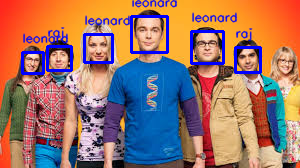

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
Previsão: [[0.19432867 0.31504735 0.27355063 0.21707341]]
Classe prevista: 1
Label correspondente: leonard
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
Previsão: [[0.20329799 0.28755012 0.27752256 0.23162922]]
Classe prevista: 1
Label correspondente: leonard
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Previsão: [[0.20391172 0.29376554 0.2645378  0.23778495]]
Classe prevista: 1
Label correspondente: leonard


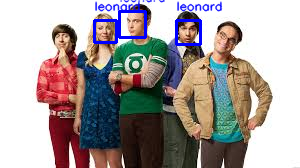

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Previsão: [[0.21572329 0.28164136 0.25996658 0.2426688 ]]
Classe prevista: 1
Label correspondente: leonard
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Previsão: [[0.21203825 0.28093913 0.2767649  0.23025769]]
Classe prevista: 1
Label correspondente: leonard


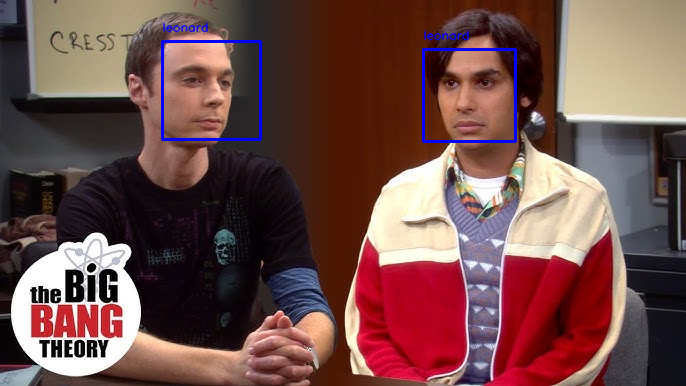

In [ ]:
# Processar cada imagem
for image_path in image_paths:
    detect_and_classify_faces(image_path, model, face_classifier, labels)